# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1685858767144'),
 ('spark.driver.port', '57684'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.rdd.compress', 'True'),
 ('spark.ap

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# load in the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [9]:
df.count()

286500

In [10]:
dfpd = pd.DataFrame(df.take(3), columns=df.columns)
dfpd

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Remove Missing Values Rows

In [11]:
df = df.dropna(subset = ["userId", "sessionId"])

In [12]:
df.count()

286500

In [13]:
df.dropDuplicates()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [14]:
df = df.filter(df["userId"] != "")

In [15]:
df.count()

278154

In [16]:
df_pandas = df.toPandas()
df_pandas 

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


In [17]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [18]:
df_pandas.shape

(278154, 18)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [20]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [21]:
cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [22]:
df = df.withColumn("churn", cancelation_event("page"))

In [23]:
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [24]:
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
dfpd = df.toPandas()
dfpd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [26]:
dataframe_churn = df.select(['userId', 'churn'])

In [27]:
dataframe_churn = dataframe_churn.dropDuplicates()

In [28]:
dataframe_churn = dataframe_churn.groupBy('churn').count()

In [29]:
dataframe_churn = dataframe_churn.toPandas()

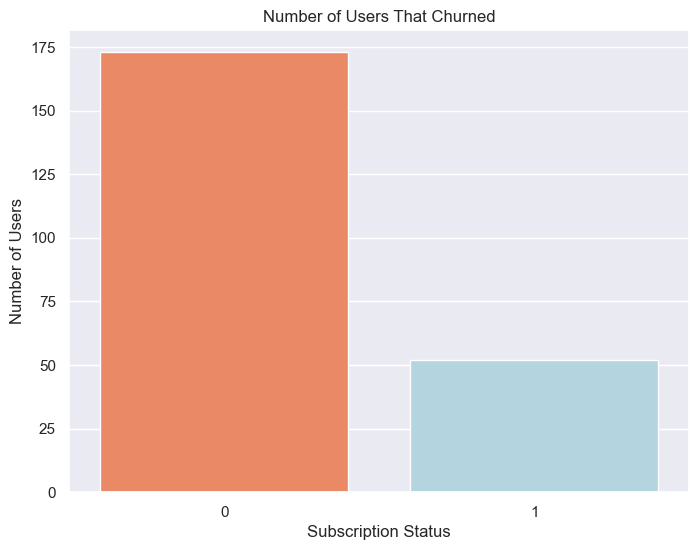

In [30]:
# Define a custom color scheme
colors = ['coral', 'lightblue']

# Plot the number of users that churned
plt.figure(figsize=[8, 6])
ax = sns.barplot(data=dataframe_churn, x='churn', y='count', palette=colors)
plt.title("Number of Users That Churned")
plt.xlabel("Subscription Status")
plt.ylabel("Number of Users")
plt.show()

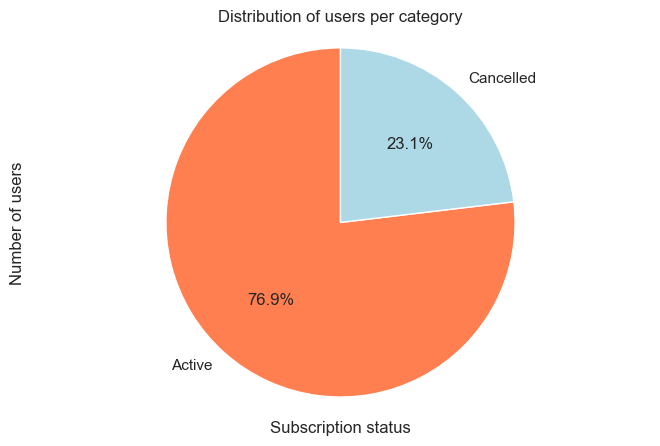

In [31]:
def plot_frequency(subset, group, labels, x_title="Subscription status", y_title="Number of users"):
    fig, ax = plt.subplots(figsize=(8, 5))
    df_grouped = dfpd.drop_duplicates(subset=subset).groupby(group)['userId'].count()
    colors = ['coral', 'lightblue']  # Define custom colors
    ax.pie(df_grouped, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Distribution of users per category')
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.show()

# Test
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

### Duration

##### Churned

In [32]:
df_len_churn = df.filter(df.churn ==1)

In [33]:
df_pd = df_len_churn.toPandas()

In [34]:
df_pd.length.dropna(inplace=True)

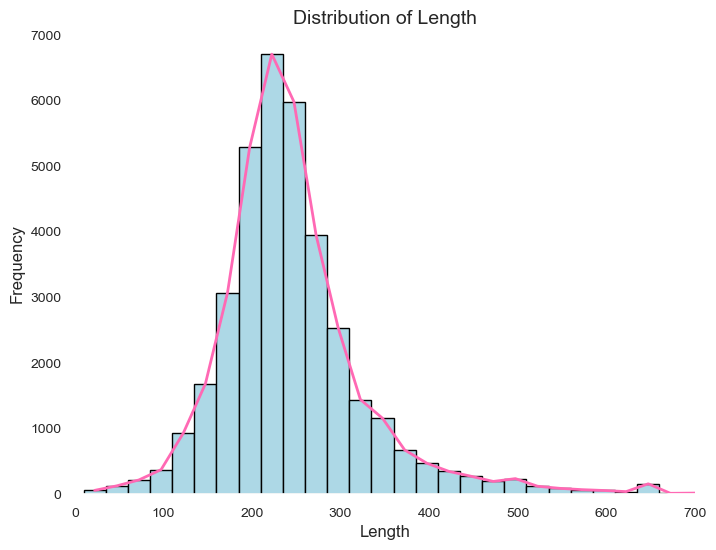

In [35]:
# Set bin edges
bin_edges = np.arange(10, df_pd['length'].max()+25, 25)

# Create a figure and axes with a white background
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('white')

# Calculate the histogram values
hist, bins, _ = ax.hist(data=df_pd, x='length', bins=bin_edges, color='lightblue', edgecolor='black')

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line plot
ax.plot(bin_centers, hist, color='hotpink', linewidth=2)

# Set the x and y axis labels and title
ax.set_xlabel('Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Length', fontsize=14)

# Set the x-axis and y-axis limits
ax.set_xlim(0, 700)
ax.set_ylim(0, None)

# Add gridlines to the plot
ax.grid(True, linestyle='--', alpha=0.5)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the tick parameters
ax.tick_params(axis='both', which='both', direction='out', labelsize=10, width=2)

# Show the plot
plt.show()

##### Stayed

In [36]:
df_len_stay = df.filter(df.churn ==0)

In [37]:
df_pd1 = df_len_stay.toPandas()

In [38]:
df_pd1.length.dropna(inplace=True)

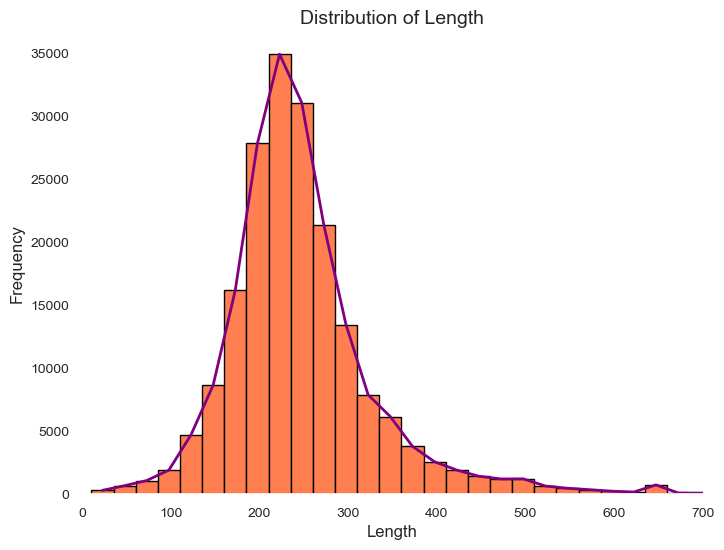

In [39]:
# Set bin edges
bin_edges = np.arange(10, df_pd1['length'].max()+25, 25)

# Create a figure and axes with a white background
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('white')

# Calculate the histogram values
hist, bins, _ = ax.hist(data=df_pd1, x='length', bins=bin_edges, color='coral', edgecolor='black')

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line plot
ax.plot(bin_centers, hist, color='purple', linewidth=2)

# Set the x and y axis labels and title
ax.set_xlabel('Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Length', fontsize=14)

# Set the x-axis and y-axis limits
ax.set_xlim(0, 700)
ax.set_ylim(0, None)

# Add gridlines to the plot
ax.grid(True, linestyle='--', alpha=0.5)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the tick parameters
ax.tick_params(axis='both', which='both', direction='out', labelsize=10, width=2)

# Show the plot
plt.show()

### Gender

In [40]:
# Select the necessary columns and drop duplicate rows
df_gender = df.select('gender', 'churn', 'userId').dropDuplicates()

# Group by 'gender' and 'churn' columns and count the number of occurrences
df_gender = df_gender.groupBy('gender', 'churn').agg(count('userId').alias('count'))

In [41]:
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [42]:
df_gender = df_gender.toPandas()

In [43]:
df_gender = df_gender.sort_values('count', ascending = False)

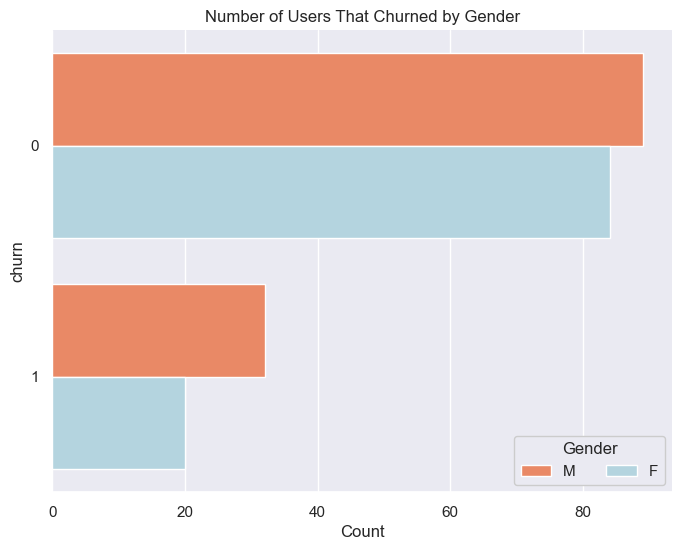

In [44]:
# Set the figure size
plt.figure(figsize=[8, 6])

# Create the bar plot using seaborn
ax = sns.barplot(data=df_gender, y='churn', x='count', hue='gender', orient='h', palette=['coral', 'lightblue'])

# Set the legend
ax.legend(loc='lower right', ncol=2, framealpha=1, title='Gender')

# Set the title
plt.title("Number of Users That Churned by Gender")

# Set the x-axis label
plt.xlabel('Count')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

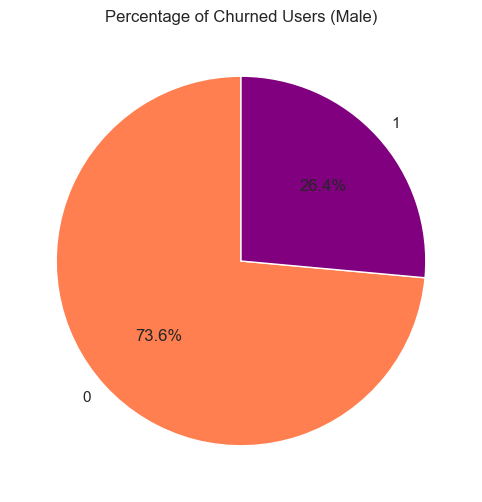

In [45]:
# Filter the dataframe for male gender (M)
df_male = df_gender[df_gender['gender'] == 'M'].copy()

# Calculate the total count of males
total_count = df_male['count'].sum()

# Calculate the percentage of males
df_male.loc[:, 'percentage'] = df_male['count'] / total_count * 100

# Set the figure size
plt.figure(figsize=[8, 6])

# Create the pie chart
plt.pie(df_male['percentage'], labels=df_male['churn'], colors=['coral', 'purple'], autopct='%1.1f%%', startangle=90)

# Set the title
plt.title("Percentage of Churned Users (Male)")

# Show the plot
plt.show()

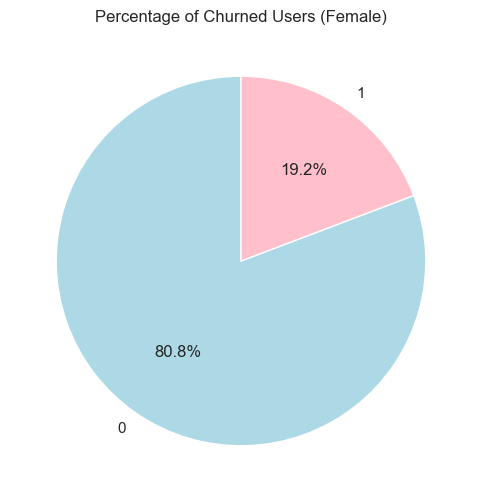

In [46]:
df_female = df_gender[df_gender['gender'] == 'F'].copy()

# Calculate the total count of females
total_count = df_female['count'].sum()

# Calculate the percentage of females
df_female.loc[:, 'percentage'] = df_female['count'] / total_count * 100

# Set the figure size
plt.figure(figsize=[8, 6])

# Create the pie chart
plt.pie(df_female['percentage'], labels=df_female['churn'], colors=['lightblue', 'pink'], autopct='%1.1f%%', startangle=90)

# Set the title
plt.title("Percentage of Churned Users (Female)")

# Show the plot
plt.show()

### Level

In [47]:
# Select the necessary columns and drop duplicate rows
df_level = df.select('level', 'churn', 'userId').dropDuplicates()

# Group by 'level' and 'churn' columns and count the number of occurrences
df_level = df_level.groupBy('level', 'churn').agg(count('userId').alias('count'))

In [48]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [49]:
df_level = df_level.toPandas()

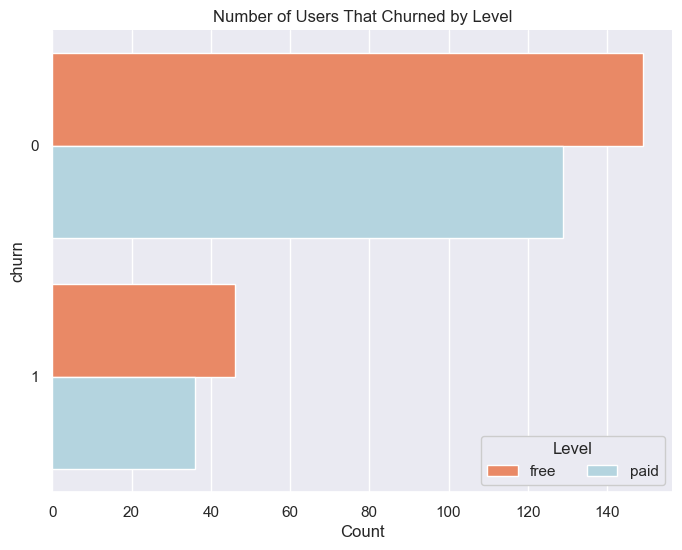

In [50]:
# Set the figure size
plt.figure(figsize=[8, 6])

# Create the bar plot using seaborn
ax = sns.barplot(data=df_level, y='churn', x='count', hue='level', orient='h', palette=['coral', 'lightblue'])

# Set the legend
ax.legend(loc='lower right', ncol=2, framealpha=1, title='Level')

# Set the title
plt.title("Number of Users That Churned by Level")

# Set the x-axis label
plt.xlabel('Count')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

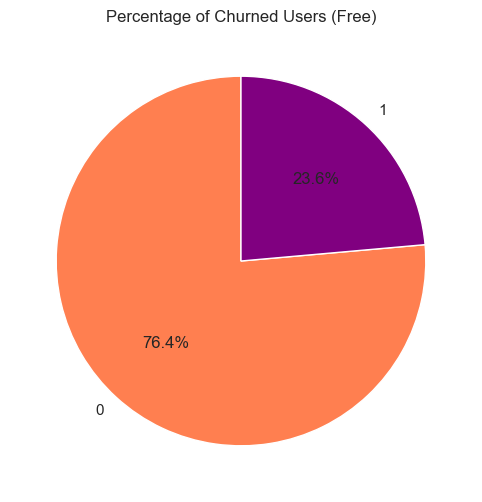

In [51]:
# Filter the dataframe for free level (free)
df_free = df_level[df_level['level'] == 'free'].copy()

# Calculate the total count of free
total_count = df_free['count'].sum()

# Calculate the percentage of free
df_free.loc[:, 'percentage'] = df_free['count'] / total_count * 100

# Set the figure size
plt.figure(figsize=[8, 6])

# Create the pie chart
plt.pie(df_free['percentage'], labels=df_free['churn'], colors=['coral', 'purple'], autopct='%1.1f%%', startangle=90)

# Set the title
plt.title("Percentage of Churned Users (Free)")

# Show the plot
plt.show()

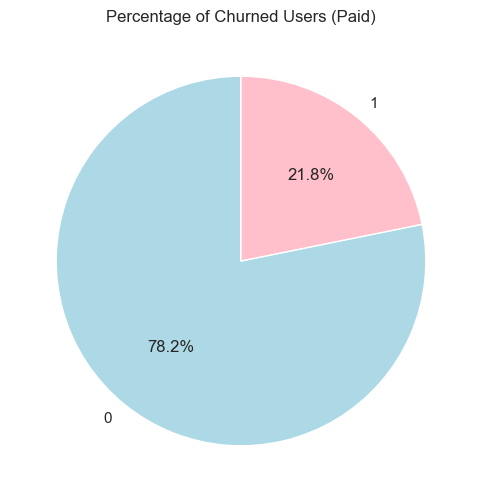

In [52]:
# Filter the dataframe for paid level (paid)
df_free = df_level[df_level['level'] == 'paid'].copy()

# Calculate the total count of paid
total_count = df_free['count'].sum()

# Calculate the percentage of paid
df_free.loc[:, 'percentage'] = df_free['count'] / total_count * 100

# Set the figure size
plt.figure(figsize=[8, 6])

# Create the pie chart
plt.pie(df_free['percentage'], labels=df_free['churn'], colors=['lightblue', 'pink'], autopct='%1.1f%%', startangle=90)

# Set the title
plt.title("Percentage of Churned Users (Paid)")

# Show the plot
plt.show()

### Pages Visited

In [53]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [54]:
df_page.show()

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [55]:
df_page = df_page.toPandas()

In [56]:
churn_page_count =  df_page[df_page['churn'] == 1].sum() 
stay_page_count =  df_page[df_page['churn'] == 0].sum()

In [57]:
for index, row in df_page.iterrows():
    if row['churn'] == 0:
        df_page.loc[index, 'rate'] = row['count'] / stay_page_count['count']
    else:
        df_page.loc[index, 'rate'] = row['count'] / churn_page_count['count']

In [58]:
df_page.head()

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713


<Figure size 1200x800 with 0 Axes>

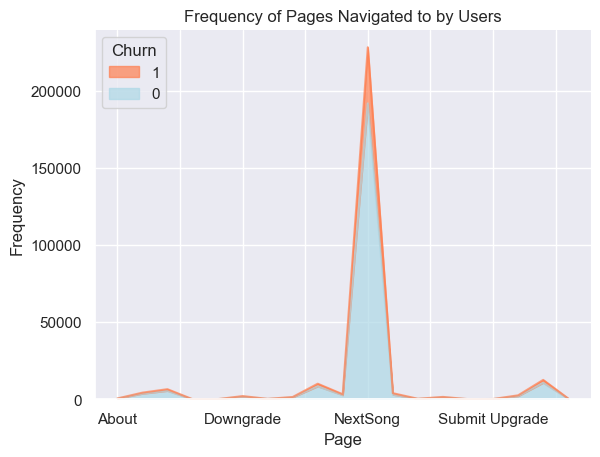

In [59]:
# Set the figure size
plt.figure(figsize=[12, 8])

# Create a pivot table to aggregate the data
pivot_table = df_page.pivot(index='page', columns='churn', values='count').fillna(0)

# Set custom colors for the plot
colors = ['lightblue', 'coral']

# Create the stacked area plot using seaborn
ax = pivot_table.plot(kind='area', stacked=True, alpha=0.7, color=colors)

# Set the title
plt.title('Frequency of Pages Navigated to by Users')

# Set the x-axis label
plt.xlabel('Page')

# Set the y-axis label
plt.ylabel('Frequency')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Churn', loc='upper left')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

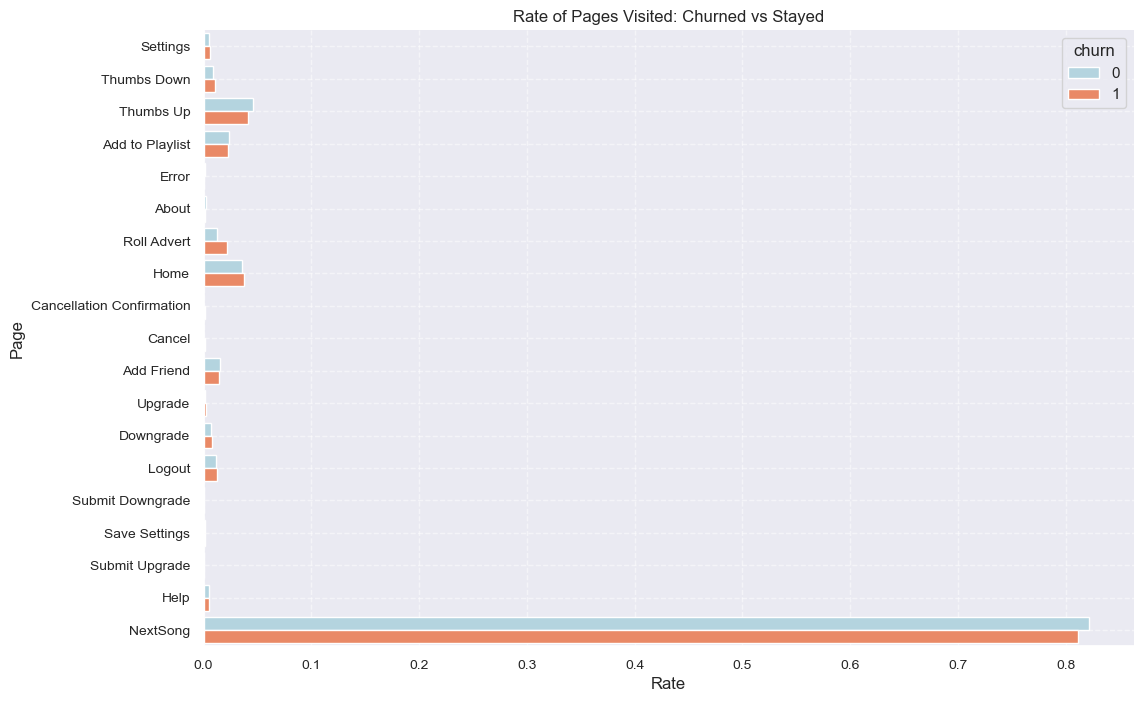

In [60]:
# Set the figure size
plt.figure(figsize=[12, 8])

# Create the bar plot using seaborn
ax = sns.barplot(data=df_page, x='rate', y='page', hue='churn', palette=['lightblue', 'coral'])

# Set the title
plt.title('Rate of Pages Visited: Churned vs Stayed')

# Set the x-axis label
plt.xlabel('Rate')

# Set the y-axis label
plt.ylabel('Page')

# Remove the top and right spines
sns.despine()

# Add gridlines to the plot
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick parameters
plt.tick_params(axis='both', which='both', direction='out', labelsize=10, width=2)

# Show the plot
plt.show()

### Determining The Number Of Songs Played Per Hour

In [61]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())

In [62]:
df = df.withColumn("hour", get_hour(col("ts")))

#### Stayed

In [63]:
songs_in_hour_stay = df.filter((col("page") == "NextSong") & (col("churn") == 0)).groupBy("hour").count().orderBy(col("hour").cast("float"))

In [64]:
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

In [65]:
songs_in_hour_stay_pd

,hour,count
0,0,9464
1,1,9146
2,2,9112
3,3,9107
4,4,8853
5,5,8526
6,6,8085
7,7,7527
8,8,7035
9,9,7014


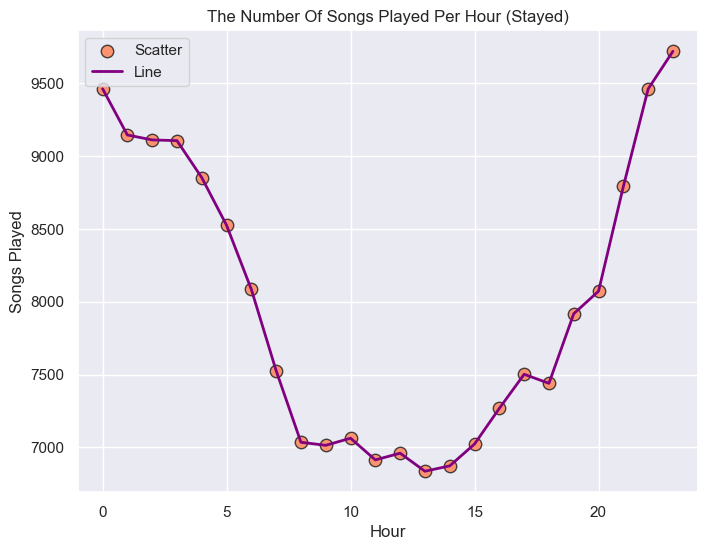

In [66]:
# Set the figure size
plt.figure(figsize=[8, 6])

# Scatter plot
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"], s=80, c="coral", alpha=0.8, edgecolors="k", label="Scatter")

# Line plot
plt.plot(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"], color="purple", linewidth=2, label="Line")

# Set the x-axis limits
plt.xlim(-1, 24)

# Set the x-axis and y-axis labels
plt.xlabel("Hour")
plt.ylabel("Songs Played")

# Set the title
plt.title("The Number Of Songs Played Per Hour (Stayed)")

# Add gridlines
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Churned

In [67]:
songs_in_hour_churned = df.filter((col("page") == "NextSong") & (col("churn") == 1)).groupBy("hour").count().orderBy(col("hour").cast("float"))

In [68]:
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

In [69]:
songs_in_hour_churned

,hour,count
0,0,1996
1,1,1978
2,2,1818
3,3,1749
4,4,1605
5,5,1596
6,6,1545
7,7,1535
8,8,1353
9,9,1322


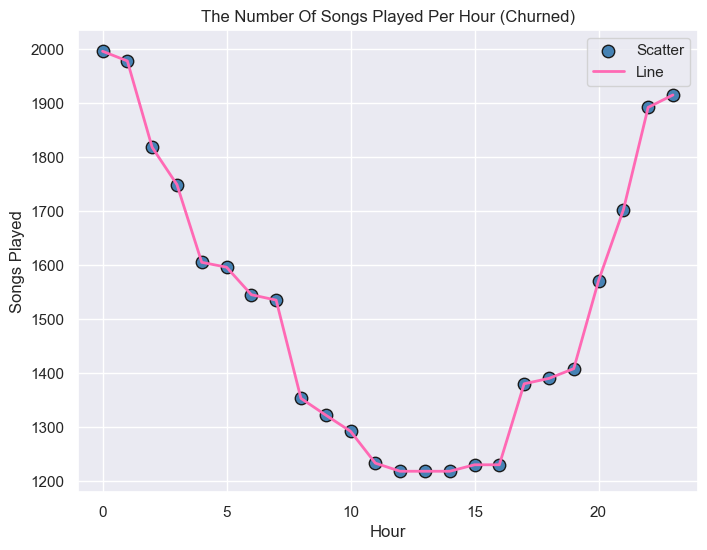

In [70]:
# Set the figure size
plt.figure(figsize=[8, 6])

# Scatter plot
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"], s=80, c="steelblue", alpha=1, edgecolors="k", label="Scatter")

# Line plot
plt.plot(songs_in_hour_churned["hour"], songs_in_hour_churned["count"], color="hotpink", linewidth=2, label="Line")

# Set the x-axis limits
plt.xlim(-1, 24)

# Set the x-axis and y-axis labels
plt.xlabel("Hour")
plt.ylabel("Songs Played")

# Set the title
plt.title("The Number Of Songs Played Per Hour (Churned)")

# Add gridlines
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Analyzing Songs per Session

In [71]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [72]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [73]:
df_songs = df_songs.toPandas()

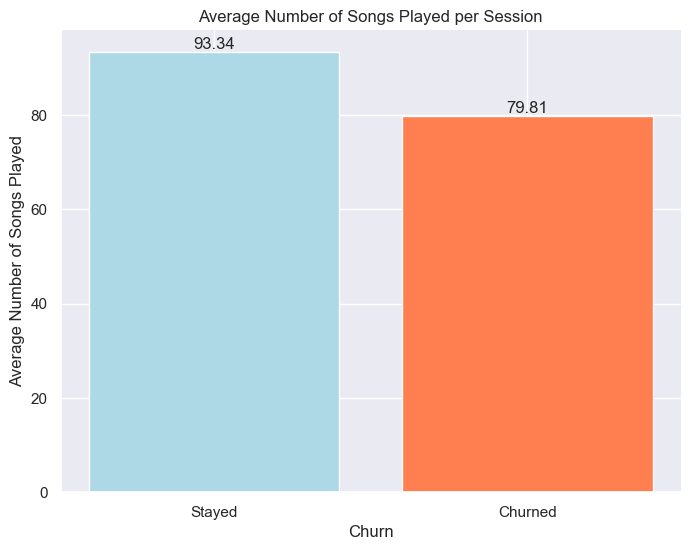

In [74]:
plt.figure(figsize=[8, 6])

# Extract the churn and average count values
churn_values = df_songs['churn'].tolist()
avg_count_values = df_songs['avg(count)'].tolist()

# Set the colors for each churn category
colors = ['lightblue', 'coral']

# Create the bar plot
plt.bar(churn_values, avg_count_values, color=colors)

# Set the title
plt.title("Average Number of Songs Played per Session")

# Set the x-axis label
plt.xlabel("Churn")

# Set the y-axis label
plt.ylabel("Average Number of Songs Played")

# Customize the x-axis tick labels
plt.xticks(churn_values, ['Stayed', 'Churned'])

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add value labels to the bars
for i, v in enumerate(avg_count_values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.show()

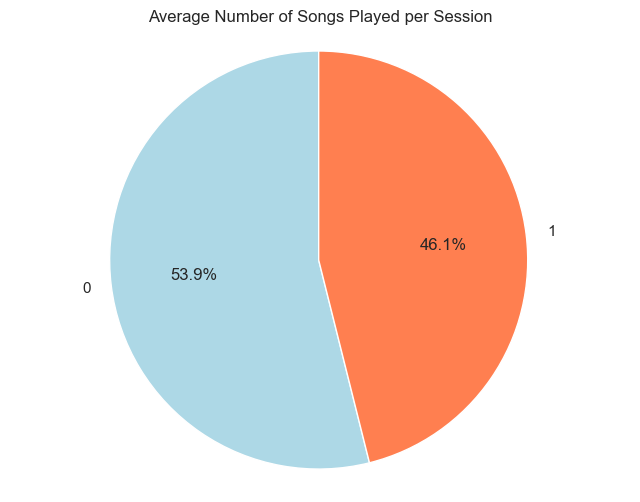

In [75]:
plt.figure(figsize=[8, 6])

# Extract the churn and average count values
churn_values = df_songs['churn'].tolist()
avg_count_values = df_songs['avg(count)'].tolist()

# Set the colors for each churn category
colors = ['lightblue', 'coral']

# Create the pie chart
plt.pie(avg_count_values, labels=churn_values, colors=colors, autopct='%1.1f%%', startangle=90)

# Set the title
plt.title("Average Number of Songs Played per Session")

# Equal aspect ratio ensures that the pie is drawn as a circle
plt.axis('equal')

plt.show()

### Analyzing the Diversity of Artists Listened to

In [76]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [77]:
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [79]:
df_artists = df_artists.toPandas()

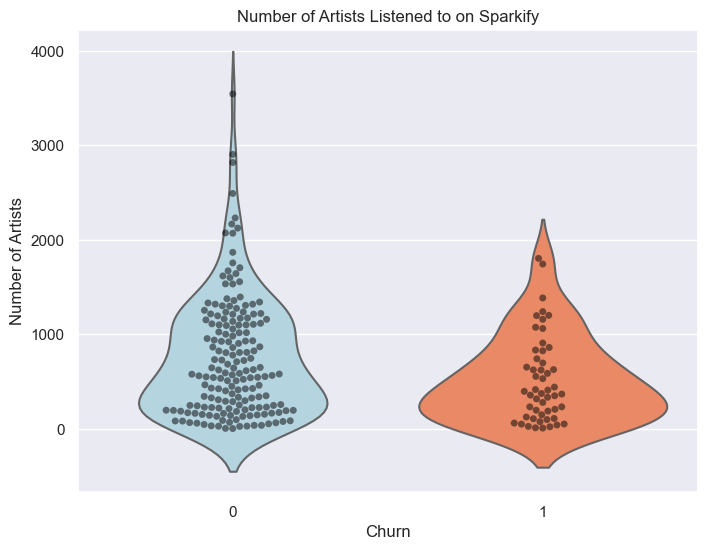

In [80]:
colors = ["lightblue", "coral"]

plt.figure(figsize=[8, 6])
sns.violinplot(data=df_artists, x='churn', y='count', inner=None, palette=colors)
sns.swarmplot(data=df_artists, x='churn', y='count', color='black', alpha=0.5)
plt.title("Number of Artists Listened to on Sparkify")
plt.xlabel("Churn")
plt.ylabel("Number of Artists")
plt.show()

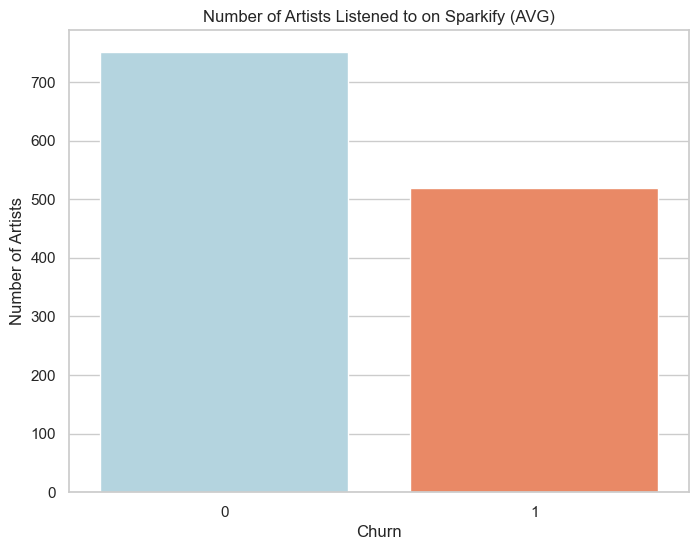

In [149]:
colors = ["lightblue", "coral"]

plt.figure(figsize=[8, 6])
sns.barplot(data=df_artists, x='churn', y='count', ci=None, palette=colors)
plt.title("Number of Artists Listened to on Sparkify (AVG)")
plt.xlabel("Churn")
plt.ylabel("Number of Artists")
plt.show()

### Analyzing User Locations

In [81]:
df_location = df.select("location", "userId", "churn").groupby("location").count()

In [82]:
get_state = udf(lambda x: x[-2:])

In [83]:
df_state = df.withColumn("state", get_state(df.location))

In [84]:
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [85]:
df_state_pd = df_state.toPandas()

In [86]:
df_state_pd.head()

,state,churn,count
0,AL,0,4
1,IL,0,8
2,AZ,1,2
3,OH,0,1
4,AL,1,2


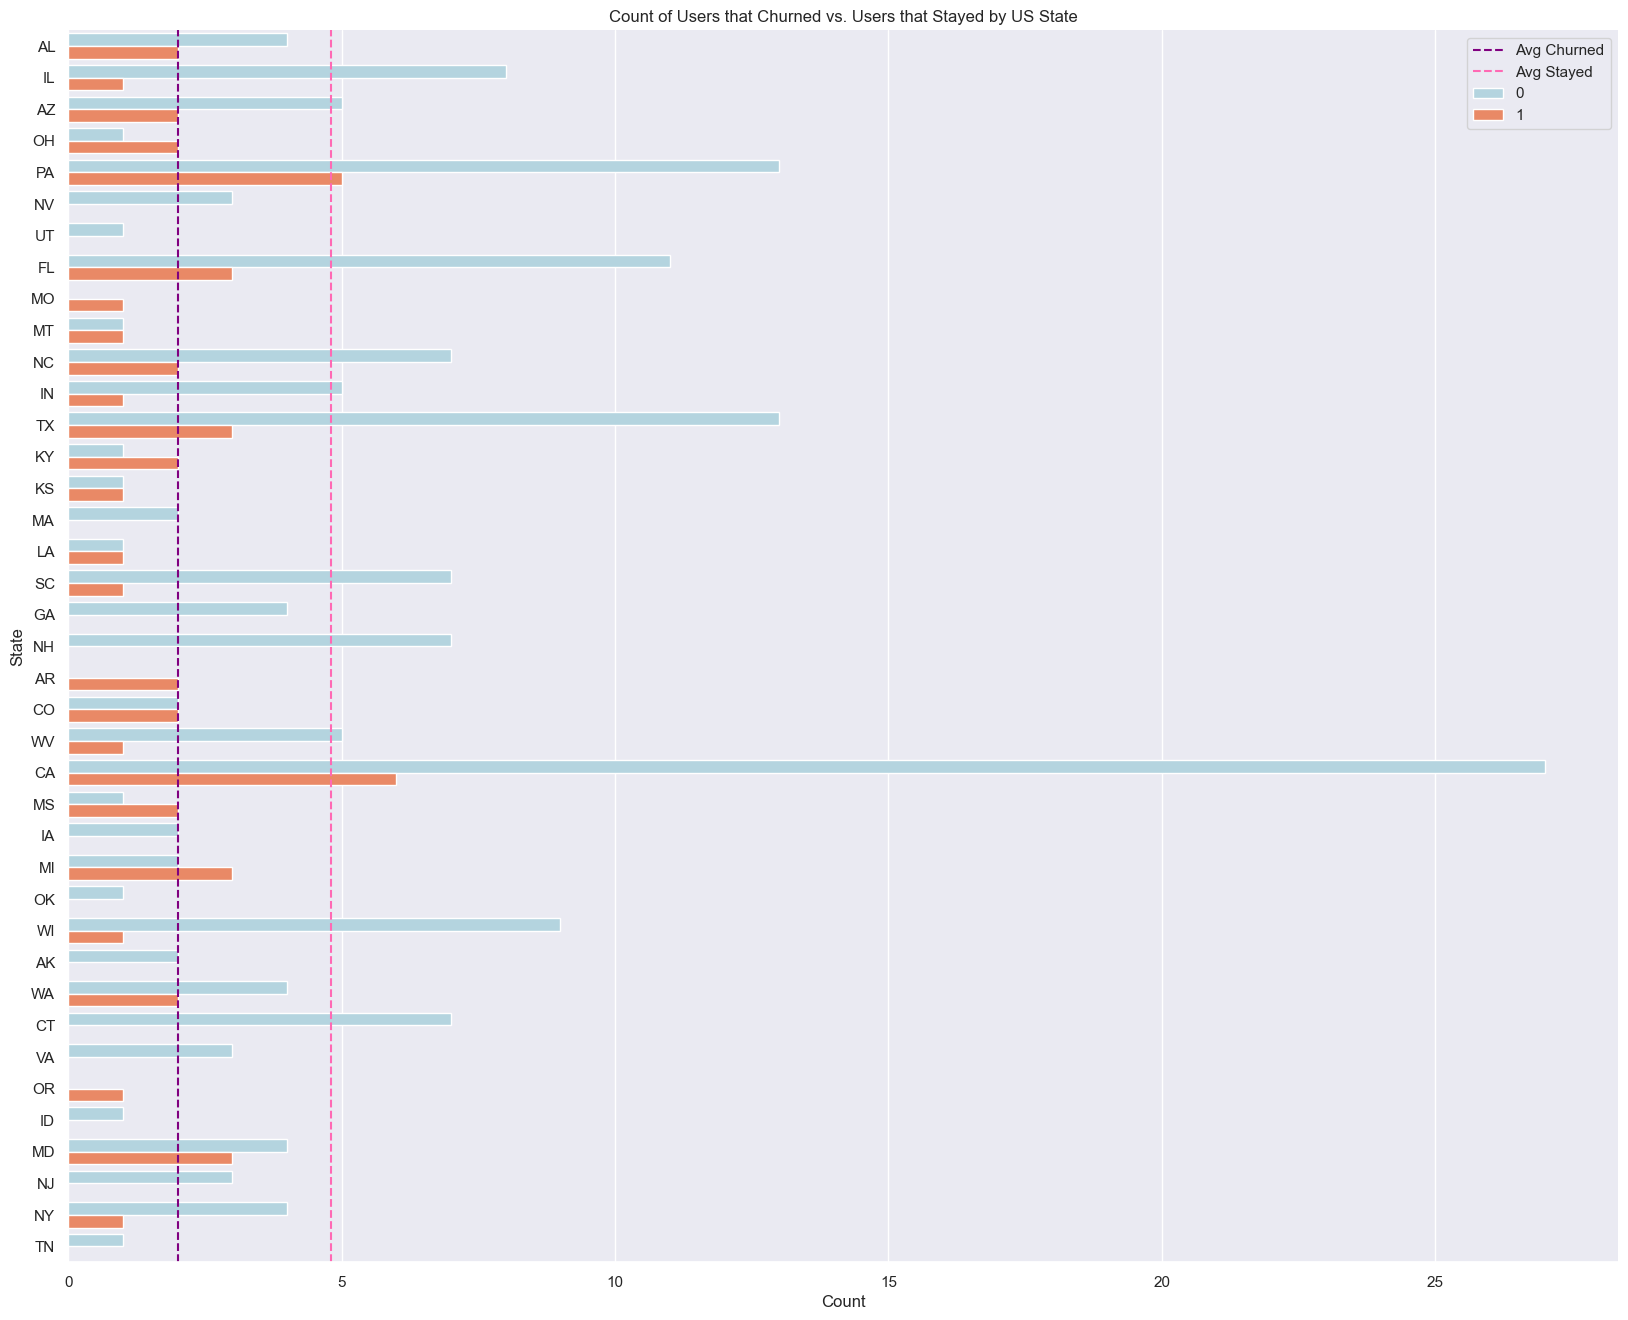

In [87]:
# Set the figure size
plt.figure(figsize=[20, 16])

# Create the bar plot using seaborn with custom palette
ax = sns.barplot(data=df_state_pd, x='count', y='state', hue='churn', palette=['lightblue', 'coral'])

# Set the title
plt.title('Count of Users that Churned vs. Users that Stayed by US State')

# Set the x-axis label
plt.xlabel('Count')

# Set the y-axis label
plt.ylabel('State')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Churn', loc='upper right')

# Add vertical lines to highlight the average counts
avg_churned = df_state_pd[df_state_pd['churn'] == 1]['count'].mean()
avg_stayed = df_state_pd[df_state_pd['churn'] == 0]['count'].mean()
plt.axvline(x=avg_churned, color='purple', linestyle='--', label='Avg Churned')
plt.axvline(x=avg_stayed, color='hotpink', linestyle='--', label='Avg Stayed')
plt.legend()

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

### Days Since Registration for Sparkify

In [88]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [89]:
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [90]:
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [91]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [92]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [93]:
df_days_pd = df_days.toPandas()

C:\Users\PC\AppData\Local\Temp\ipykernel_16724\2541840945.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=10)


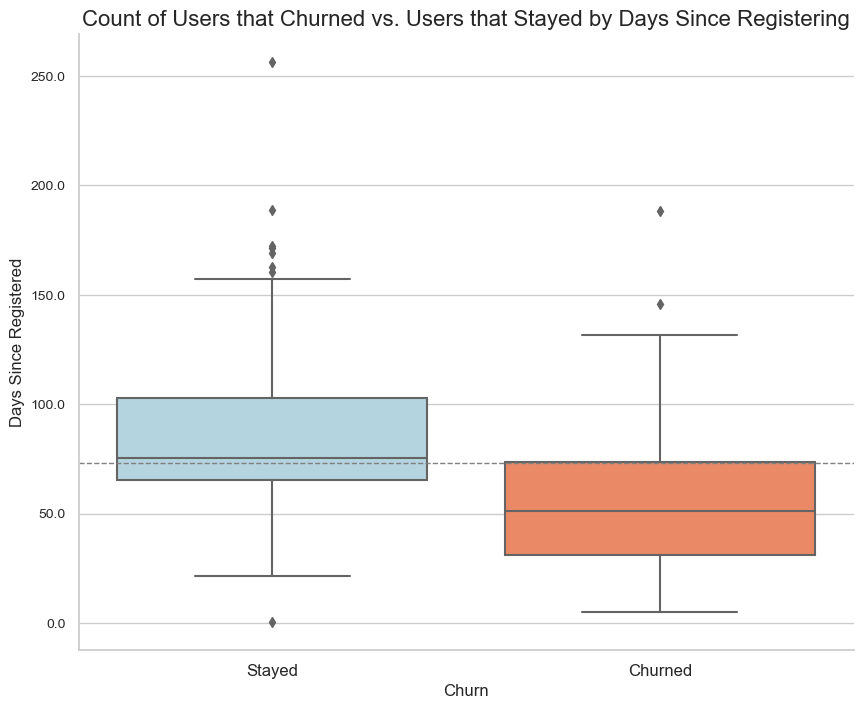

In [94]:
# Set the figure size and style
plt.figure(figsize=[10, 8])
sns.set(style="whitegrid")

# Create the box plot using seaborn with custom palette
ax = sns.boxplot(data=df_days_pd, x='churn', y='days', palette=['lightblue', 'coral'])

# Set the title
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering', fontsize=16)

# Set the x-axis label
plt.xlabel('Churn', fontsize=12)

# Set the y-axis label
plt.ylabel('Days Since Registered', fontsize=12)

# Customize the tick labels
ax.set_xticklabels(['Stayed', 'Churned'], fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=10)

# Add a horizontal line at the median
ax.axhline(y=df_days_pd['days'].median(), color='gray', linestyle='--', linewidth=1)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_16724\75607378.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=10)


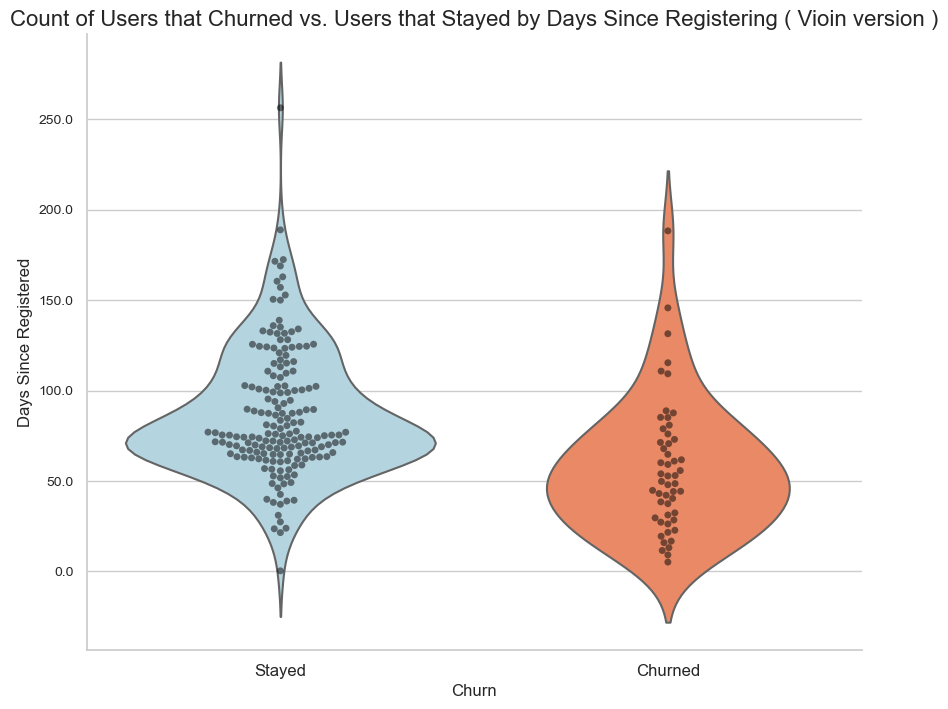

In [95]:
# Set the figure size and style
plt.figure(figsize=[10, 8])
sns.set(style="whitegrid")

# Create the violin plot using seaborn with custom palette
ax = sns.violinplot(data=df_days_pd, x='churn', y='days', inner=None, palette=['lightblue', 'coral'])

# Add individual data points using swarmplot
sns.swarmplot(data=df_days_pd, x='churn', y='days', color='black', alpha=0.5)

# Set the title
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering ( Vioin version )', fontsize=16)

# Set the x-axis label
plt.xlabel('Churn', fontsize=12)

# Set the y-axis label
plt.ylabel('Days Since Registered', fontsize=12)

# Customize the tick labels
ax.set_xticklabels(['Stayed', 'Churned'], fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=10)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Gender

In [96]:
# Select the required columns and drop duplicates
user_gender_f1 = df.select(['userId', 'gender']).dropDuplicates()

# Convert 'gender' column values to 1 if 'F' or 0 otherwise
user_gender_f1 = user_gender_f1.withColumn('gender', (col('gender') == 'F').cast('integer'))

# Count the number of rows in user_gender_f1
user_gender_f1.count()

225

In [97]:
user_gender_f1.toPandas().head(20)

,userId,gender
0,44,1
1,46,1
2,41,1
3,39,1
4,40,1
5,94,1
6,35,1
7,75,1
8,100,0
9,25,1


### Level

In [98]:
# Select the required columns and drop duplicates, sort by userId
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

# Create a window function to assign ranks within each userId partition based on descending ts
w = Window.partitionBy("userId").orderBy(desc("ts"))

# Add a 'Rank' column using dense_rank function
df2 = df2.withColumn("Rank", dense_rank().over(w))

# Filter rows with Rank equal to 1, drop the Rank column
user_level_f2 = df2.filter(df2.Rank == 1).drop('Rank')

# Drop the 'ts' column
user_level_f2 = user_level_f2.drop('ts')

# Map the 'level' column values to 1 if 'paid' or 0 otherwise
user_level_f2 = user_level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

# Count the number of rows in user_level_f2
user_level_f2.count()

225

In [99]:
user_level_f2.toPandas().head(10)

,userId,level
0,10,1
1,100,1
2,100001,0
3,100002,1
4,100003,0
5,100004,1
6,100005,0
7,100006,0
8,100007,1
9,100008,0


### Average Number of Songs Played per Session

In [100]:
# Filter and group by userId and sessionId, and count the occurrences
song_sessions_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

# Group by userId and calculate the average count
song_sessions_f3 = song_sessions_f3.groupby('userId').agg(avg("count").alias("avg_song"))

# Rename the column to "avg_song"
song_sessions_f3 = song_sessions_f3.withColumnRenamed("avg_song", "avg_song")

# Count the number of rows in song_sessions_f3
song_sessions_f3.count()

225

In [101]:
song_sessions_f3.toPandas().head()

,userId,avg_song
0,100010,39.285714
1,200002,64.500000
2,125,8.000000
3,124,145.678571
4,51,211.100000


### Number of different Artists Listened to on Sparkify

In [102]:
# Select the required columns and drop duplicates
artists_f4 = df.select("userId", "artist").dropDuplicates().groupBy("userId").count()

# Rename the 'count' column to 'num_artists'
artists_f4 = artists_f4.withColumnRenamed("count", "num_artists")

# Count the number of rows in artists_f4
count = artists_f4.count()

In [103]:
artists_f4.toPandas().head()

,userId,num_artists
0,100010,253
1,200002,340
2,125,9
3,51,1386
4,124,2233


### Days Since Registration for Sparkify

In [104]:
# Drop the specified columns from df_days
days_f5 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

# Count the number of rows in days_f5
count = days_f5.count()

In [105]:
df_days.toPandas().head(20)

,userId,registration,ts,churn,delta_days,days
0,10,1538159495000,1542631788000,0,4472293000,51.762650
1,100,1537982255000,1543587349000,0,5605094000,64.873773
2,100001,1534627466000,1538498205000,1,3870739000,44.800220
3,100002,1529934689000,1543799476000,0,13864787000,160.472072
4,100003,1537309344000,1539274781000,1,1965437000,22.748113
5,100004,1528560242000,1543459065000,0,14898823000,172.440081
6,100005,1532610926000,1539971825000,1,7360899000,85.195590
7,100006,1537964483000,1538753070000,1,788587000,9.127164
8,100007,1533522419000,1543491909000,1,9969490000,115.387616
9,100008,1537440271000,1543335219000,0,5894948000,68.228565


### Churn Label

In [106]:
churn_label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
churn_label = churn_label.drop('count')
churn_label.count()

225

In [107]:
churn_label = churn_label.withColumnRenamed("churn", "label")
churn_label.toPandas().head()

,userId,label
0,10,0
1,100,0
2,100001,1
3,100002,0
4,100003,1


### Feature

In [109]:
feature = user_gender_f1.join(user_level_f2, ["userId"]).join(song_sessions_f3, ["userId"]).join(artists_f4, ["userId"]).join(days_f5, ["userId"]).join(churn_label, ["userId"])

In [110]:
feature = feature.drop('userId')
feature.toPandas().head(20)

,gender,level,avg_song,num_artists,days,label
0,0,1,112.166667,566,51.762650,0
1,0,1,78.882353,1706,64.873773,0
2,1,0,33.250000,126,44.800220,1
3,1,1,48.750000,185,160.472072,0
4,1,0,25.500000,51,22.748113,1
5,1,1,47.100000,734,172.440081,0
6,0,0,38.500000,150,85.195590,1
7,1,0,26.000000,27,9.127164,1
8,1,1,47.000000,358,115.387616,1
9,1,0,128.666667,624,68.228565,0


In [111]:
# Iterate over the columns of feature dataframe
for i in feature.columns:
    # Convert the column to float data type
    feature = feature.withColumn(i, col(i).cast('float'))

In [112]:
feature.printSchema()

root
 |-- gender: float (nullable = true)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



In [113]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song","num_artists", "days"], outputCol = "vec_features")

In [114]:
feature = assembler.transform(feature)

In [115]:
feature.show()

+------+-----+----------+-----------+---------+-----+--------------------+
|gender|level|  avg_song|num_artists|     days|label|        vec_features|
+------+-----+----------+-----------+---------+-----+--------------------+
|   0.0|  1.0|112.166664|      566.0| 51.76265|  0.0|[0.0,1.0,112.1666...|
|   0.0|  1.0| 78.882355|     1706.0| 64.87377|  0.0|[0.0,1.0,78.88235...|
|   1.0|  0.0|     33.25|      126.0| 44.80022|  1.0|[1.0,0.0,33.25,12...|
|   1.0|  1.0|     48.75|      185.0|160.47208|  0.0|[1.0,1.0,48.75,18...|
|   1.0|  0.0|      25.5|       51.0|22.748114|  1.0|[1.0,0.0,25.5,51....|
|   1.0|  1.0|      47.1|      734.0|172.44008|  0.0|[1.0,1.0,47.09999...|
|   0.0|  0.0|      38.5|      150.0| 85.19559|  1.0|[0.0,0.0,38.5,150...|
|   1.0|  0.0|      26.0|       27.0| 9.127164|  1.0|[1.0,0.0,26.0,27....|
|   1.0|  1.0|      47.0|      358.0|115.38762|  1.0|[1.0,1.0,47.0,358...|
|   1.0|  0.0| 128.66667|      624.0| 68.22856|  0.0|[1.0,0.0,128.6666...|
|   0.0|  0.0|      51.8|

In [116]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [117]:
scaler_model = scaler.fit(feature)

In [118]:
feature = scaler_model.transform(feature)

In [119]:
train, test, valid = feature.randomSplit([0.6, 0.2, 0.2], seed=2023)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:126
Test Dataset:57
Validation Dataset:41


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [120]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=2023)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=2023)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [121]:
models = [lr,rf,gbt,lsvc,nb]

In [122]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [159]:
 for model in models:
        # Get model name
        model_name = model.__class__.__name__

        # Print training started
        print('Training started for', model_name)

        # Start time
        start = time.time()
        # Fit the models on the training dataset
        trained_model = model.fit(train)
        # End time
        end = time.time()

        # Print training ended
        print('Training ended for', model_name)
        # Print time taken
        print('Time taken for', model_name, 'is:', (end - start), 'seconds')

        # Predict
        print('Predicting started for', model_name)
        predictions = trained_model.transform(valid)
        print('Predicting ended for', model_name)

        # Get metrics to evaluate
        # F1 score
        print('F1 score for', model_name, 'is:', evaluator.evaluate(predictions, {evaluator.metricName: 'f1'}))
        # Accuracy
        accuracy = predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()
        print('The accuracy of', model_name, 'is:', accuracy)

Training started for LogisticRegression
Training ended for LogisticRegression
Time taken for LogisticRegression is: 103.58312940597534 seconds
Predicting started for LogisticRegression
Predicting ended for LogisticRegression
F1 score for LogisticRegression is: 0.7914053426248548
The accuracy of LogisticRegression is: 0.8048780487804879
Training started for RandomForestClassifier
Training ended for RandomForestClassifier
Time taken for RandomForestClassifier is: 136.97238731384277 seconds
Predicting started for RandomForestClassifier
Predicting ended for RandomForestClassifier
F1 score for RandomForestClassifier is: 0.8141167775314115
The accuracy of RandomForestClassifier is: 0.8048780487804879
Training started for GBTClassifier
Training ended for GBTClassifier
Time taken for GBTClassifier is: 54.51702833175659 seconds
Predicting started for GBTClassifier
Predicting ended for GBTClassifier
F1 score for GBTClassifier is: 0.7808811959087333
The accuracy of GBTClassifier is: 0.75609756097

### Random Forest

In [124]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [125]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="f1")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [126]:
cvModel = crossval.fit(train)

In [127]:
cvModel.avgMetrics

[0.7298851972850402,
 0.7351980907472898,
 0.7351980907472898,
 0.7502601996909778,
 0.7573191062893581,
 0.7573191062893581,
 0.7823130463402029,
 0.7997681435915651,
 0.7997681435915651]

In [128]:
results = cvModel.transform(valid)

In [129]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

### Best Model

In [130]:
best_model = cvModel.bestModel

In [157]:
print('The F1 score for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

The F1 score for our best model is: 0.7518699186991871


In [158]:
print('The accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

The accuracy for our best model is: 0.8292682926829268


In [134]:
importances = best_model.featureImportances

In [135]:
x_values = list(range(len(importances)))

### Importance of Features

In [136]:
feature_list = list(["gender", "level", "avg_song", "num_artists", "days"])

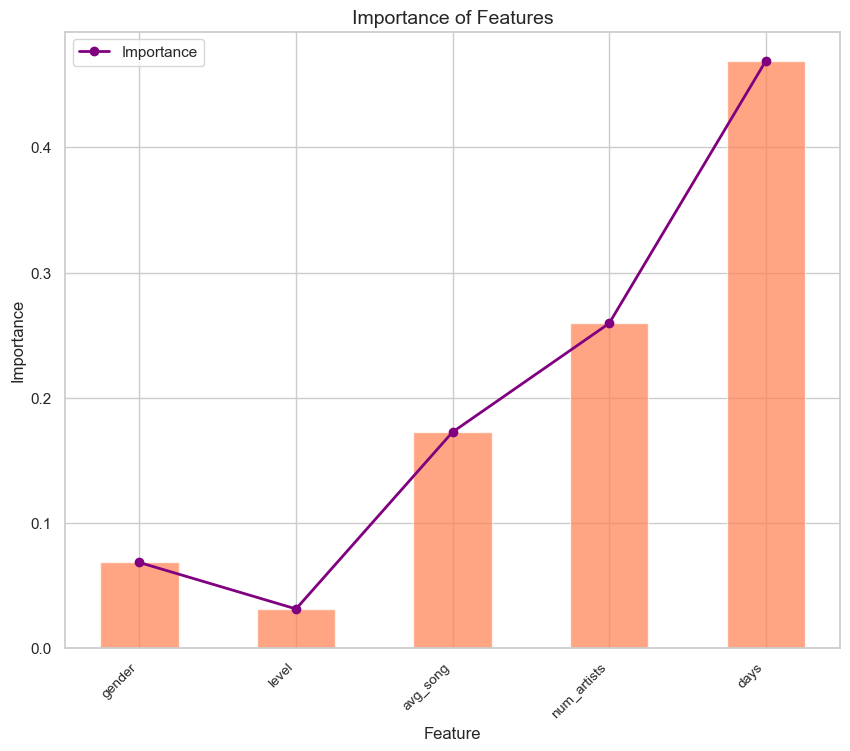

In [155]:
plt.figure(figsize=[10, 8])  # Set the figure size

# Draw the bar chart
plt.bar(x_values, importances, width=0.5, color='coral', alpha=0.7)

# Set and rotate the x-axis labels
plt.xticks(x_values, feature_list, rotation=45, ha='right', fontsize=10)

# Set the y-axis and x-axis labels
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Feature', fontsize=12)

# Add a line plot
plt.plot(x_values, importances, marker='o', color='purple', linewidth=2, label='Importance')

# Set the title for the chart
plt.title('Importance of Features', fontsize=14)

# Add a legend
plt.legend()

# Display the chart
plt.show()

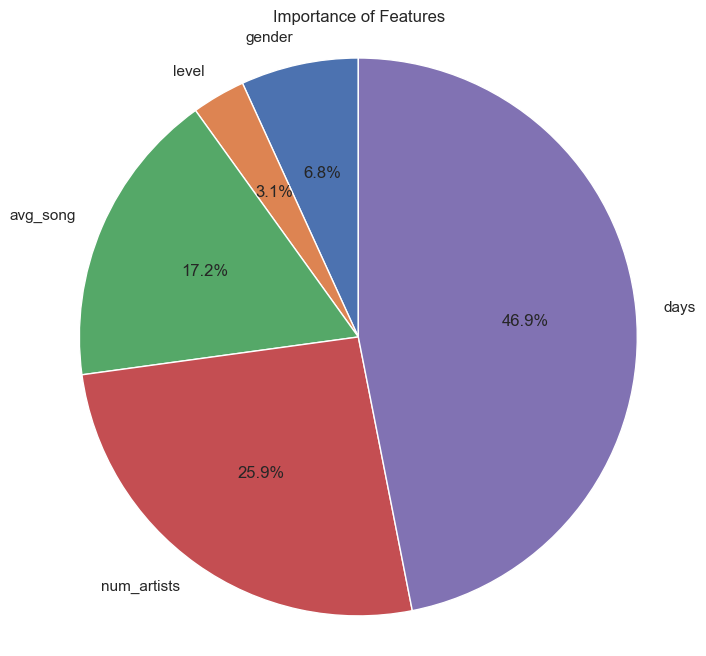

In [160]:
plt.figure(figsize=[8, 8])
plt.pie(importances, labels=feature_list, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Importance of Features')
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### In conclusion:

Our project commenced with a small dataset of only 128MB. After performing data loading and cleaning, we delved into the dataset to identify valuable features for predicting churn and successfully developed the most promising ones. Subsequently, we preprocessed these features and utilized them with various machine learning algorithms.

### Impact on the Business:

With this newfound information, Sparkify can employ a strategic approach to retain customers who are at risk of churning, leading to a positive impact on the company's bottom line. By customizing incentives tailored to individual customers, Sparkify can effectively entice them to remain loyal, thus preserving revenue while providing customers with favorable offers. Our analysis has indicated that newer customers are particularly susceptible to churning, making them a prime target for intervention. To address this, we can offer these customers a complimentary trial of our premium service, free from any disruptive advertisements. Furthermore, Sparkify has the opportunity to enhance its music recommendation system, ensuring that users receive personalized song suggestions that align with their preferences and minimize disliked content.

### The project was fantastic for me:

Throughout this project, I acquired proficiency in manipulating datasets using Spark to engineer relevant features for churn prediction. I employed Spark MLib to construct machine learning models for churn prediction. It was fascinating to begin with a dataset encompassing users' interactions and utilize it to forecast their likelihood of churn. The Random Forest classifier emerged as the best model, attaining an accuracy. Building my initial churn prediction model in PySpark, as opposed to pandas, added an interesting dimension to the project.

###### Finally, I would like to thank Udacity and all parties involved for providing such interesting knowledge. It truly gives me a proper perspective on data science, and I hope in the future I can apply all the knowledge I have learned to real-life projects. Once again, thank you very much.